In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial B5: Variant Effect

A common use-case of sequence-based machine learning methods is predicting the effects of variants. By comparing the predictions of the model before and after incorporating a variant one can evaluate the predicted effect and, potentially, better understand the mechanism of its action. For example, let's pretend that we have a model that predicts the binding of some protein of interest. If this model predicts binding on a reference sequence but no longer predicts binding after including the variant, it would be reasonable to assume that (1) the variant could be involved in some downstream change in phenotype or (2) if the variant is already connected to some phenotype that the mechanism of its action might be through the blocking of the binding of this protein.  In contrast, if a variant does not change the predictions from the model, potentially it is not involved with the change in phenotype.

There are many kinds of variants and some kinds are not trivial to calculate the effect for. The most basic kind are <i>substitutions</i>, where one or more characters is/are changed into another/other characters. A more complicated sort of variant is the <i>deletion</i>, where characters in one sequence are not present in the other sequence. Finally, there is the conceptual opposite of the deletion, the <i>insertion</i>, where characters are present in the other sequence but not the original sequence. Naturally, deletions and insertions are both relative, in the sense that what is viewed as a deletion in one set of sequences is just an insertion if you flip the reference. However, in genomics, we are usually using a reference genome and so deletions and insertions are distinguished according to the reference.

Usually, calculating variant effect for substitutions is trivial because characters are simply swapped; however, calculating variant effect for insertions or deletions can be challenging because the two sequences are no longer the same length and most machine learning methods assume a fixed window length. Below, we will walk through what `tangermeme` does for each sort of variant.

#### Substitutions

The simplest form of variant is the substitution, where one or more characters are exchanged for other characters. These variants are the simplest to evaluate because one can simply run the original sequence through the model, make the substitutions, and run the new sequence through the model as well -- the original and modified sequences are both of the same length.

We can use `tangermeme` to calculate these effects using the `substitution_effect` function. This function takes in a model, a set of original sequences (before inclusion of the variant), a COO-sparse matrix of substitutions, and optional additional arguments to pass into the provided function. Each line in the matrix of substitutions should be one substitution with the first column being the example, the second column being the position within the example, and the third column being the character that should appear at that position in that example. An important note is that this allows for multiple substitutions to be included in the same examples by having multiple lines with the same example index.

For the purpose of demontrating the usage we can use our simple untrained dense model again.

In [2]:
import torch
from tangermeme.utils import random_one_hot

class FlattenDense(torch.nn.Module):
	def __init__(self, seq_len=10):
		super(FlattenDense, self).__init__()
		self.dense = torch.nn.Linear(seq_len*4, 3)
		self.seq_len = seq_len

	def forward(self, X, alpha=0, beta=1):
		X = X.reshape(X.shape[0], self.seq_len*4)
		return self.dense(X) * beta + alpha

model = FlattenDense()

Let's start off by generating a random sequence.

In [3]:
from tangermeme.utils import random_one_hot

X = random_one_hot((1, 4, 10), random_state=0)

Next, let's create the substitutions. Let's say that we want to add in a `C` at position 4 (0-indexed) and a `G` at position 5.

In [4]:
substitutions = torch.tensor([
    [0, 4, 1],   # Example index 0, position 4, C is index 1
    [0, 5, 2]    # Example index 0, position 5, G is index 2
])

Now that we have our model, our original sequences, and our references, we can use the `substitution_effect` function to get the model predictions before and after making the substitutions.

In [5]:
from tangermeme.variant_effect import substitution_effect

y, y_var = substitution_effect(model, X, substitutions, device='cpu')
y.shape, y_var.shape

(torch.Size([1, 3]), torch.Size([1, 3]))

The tensors have the shape `(1, 3)` because there was only one example passed in and the effect is returned on the example level, not the individual variant level. This is an important point. If you have multiple variants whose marginal effect you would like to assess (i.e., you want to put each variant individually into the sequence and see what the predictions are) you will need to copy the example repeatedly and have a substitution matrix where each substitution goes into a different copy of the example.

Further, `tangermeme` does not force the user to adopt a specific distance function. Rather, the functions returns the raw predictions with and without the substitutions and allows the user to define their own distance. For example, we could use a simple Euclidean distance function to calculate the difference between predictions before and after including the substitutions

In [6]:
torch.sqrt(torch.sum((y_var - y) ** 2, dim=-1))

tensor([0.2091])

More generally, these functions are meant to be the base operation that your downstream functions are built off of. In your library, you might write your own `variant_effect` function with a similar signature, call this function to get the predictions, calculate distance in the manner you choose, and return that -- either individually, or as part of the variant DataFrame that was passed in originally.

##### GATA2

As a more realistic example, let's look at what happens when we use a GATA2 BPNet model at a site that originally contains a GATA motif, but has to also consider a single substitution to that motif. Here, we will insert the GATA sequence into random background sequence just to quickly construct an example, and then in the substitution matrix swap one of the Ts to a C.

In [7]:
from tangermeme.ersatz import substitute

bpnet = torch.load("gata2.bpnet.torch")

X3 = random_one_hot((1, 4, 2114), random_state=0).type(torch.float32)
X3 = substitute(X3, "CTTATCT")

substitutions3 = torch.tensor([
    [0, 1058, 0]
])

y, y_var = substitution_effect(bpnet, X3, substitutions3, args=(torch.zeros(1, 2, 2114),), device='cpu')
len(y), y[0].shape, y[1].shape

(2, torch.Size([1, 2, 1000]), torch.Size([1, 1]))

BPNet models return predicted probabilities for each basepair as well as the log counts for the region. Put another way, these models are multi-output, yet the variant effect functions are still able to handle these irregular shapes because the underlying predict function handles them well. For the purpose of this example we will just take a look a the predicted probabilities.

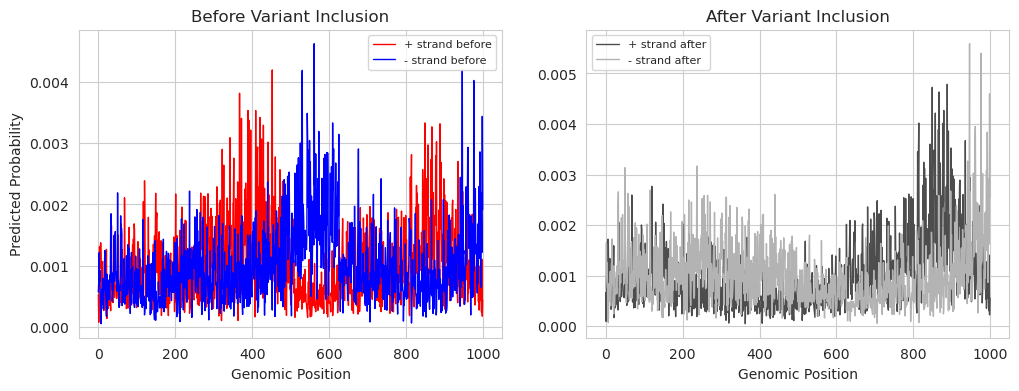

In [8]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

yb = torch.nn.functional.softmax(y[0][0], dim=-1) 
ya = torch.nn.functional.softmax(y_var[0][0], dim=-1)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Before Variant Inclusion")
plt.plot(yb[0], color='r', linewidth=1, label="+ strand before")
plt.plot(yb[1], color='b', linewidth=1, label="- strand before")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")
plt.legend(fontsize=8)

plt.subplot(122)
plt.title("After Variant Inclusion")
plt.plot(ya[0], color='0.3', linewidth=1, label="+ strand after")
plt.plot(ya[1], color='0.7', linewidth=1, label="- strand after")
plt.xlabel("Genomic Position")
plt.legend(fontsize=8)
plt.show()

It looks like that single T -> C variant causes the model to no longer predict a peak in the signal here. This is quite a dramatic change for just a single nucleotide and indicates that someone who had this variant might be worth investigating further.

##### Arguments

If you have additional arguments that need to be passed into the function you can do that through the use of the `args` argument. This argument takes in a tuple of tensors with the same first dimension as `X` and where the i-th entry in `X` gets processed with the i-th entry in each of the tensors in `args`. So, with our dense example, we can pass in tensors of alphas and betas as well.

In [9]:
X2 = random_one_hot((8, 4, 10), random_state=0)
alpha = torch.randn(8, 1)
beta = torch.randn(8, 1)

y, y_var = substitution_effect(model, X2, substitutions, args=(alpha, beta), device='cpu')
y.shape, y_var.shape

(torch.Size([8, 3]), torch.Size([8, 3]))

Here, we aren't actually making substitutions past the first example because we are using the same substitution matrix as before, but the point is to demonstrate how to pass additional arguments into the forward function of your model.

##### Attributions

By default, predictions are returned before and after the variants are included in the examples. However, like other functions in `tangermeme`, any function can be passed in to be applied before the variants are included. For example, if we wanted to get attributions before and after the substitutions we could do the following:

In [10]:
from tangermeme.deep_lift_shap import deep_lift_shap

y, y_var = substitution_effect(model, X, substitutions, func=deep_lift_shap, device='cpu')
y.shape, y_var.shape

(torch.Size([1, 4, 10]), torch.Size([1, 4, 10]))

Note here that the shape is different because the model makes three predictions per example, yielding a shape of `(1, 3)`, but the attributions are one value for each input feature and so match the shape of `X`.

Also like other functions, if we want to pass arguments into the `deep_lift_shap` function we can either simly pass them into `substitution_effect` or we can pass them as a dictionary into `additional_func_kwargs`.

In [11]:
y, y_var = substitution_effect(model, X, substitutions, func=deep_lift_shap, device='cpu', n_shuffles=2)
y.shape, y_var.shape

(torch.Size([1, 4, 10]), torch.Size([1, 4, 10]))

In [12]:
y, y_var = substitution_effect(model, X, substitutions, func=deep_lift_shap, device='cpu', additional_func_kwargs={'n_shuffles': 2})
y.shape, y_var.shape

(torch.Size([1, 4, 10]), torch.Size([1, 4, 10]))

In case you missed it, this is to allow an option to completely ensure that arguments are passed solely into the function and do not get used by `substitution_effect` instead. 

#### Deletions

Another form of variant is a deletion, where a character is removed from the sequence. Evaluating deletions is a little more challenging than substitutions because, with substitutions, every character remains the same except for the substitutions and -- more importantly -- the length of the sequence does not change. With a deletion, many characters will appear to change because they are being moved over by one or more positions. Afterward, the sequence with the deletions will be shorter than the original sequence, which poses challenges if the model expects sequences of the same length. Like with substitutions, multiple deletions can be specified for each sequence.

These issues are overcome in `tangermeme` by, simply put, having the user load more sequence into each example and then slicing sequences to make them ultimately be the same length. More specifically, if the maximum number of deletions in one of the examples is 6 and the model expects a sequence of length 100 then the user must provide tensors with 106 positions for each example. This way, even after incorporating deletions in the sequence with the most deletions, all sequences will have at least the 100 positions the model expects.

However, this does not completely solve the issue. First, the original sequences still all have 106 positions in them. Second, not all sequences will be incorporating 6 deletions and so will have different lengths. The solution to both of these problems involves trimming: trimming the original sequences down to 100 positions by removing 6 from an edge, and trimming a variable number of positions from each variant-incorporated sequence to get them down to 100 positions. Because one could trim from either the left or right side, the user specified `left=True` which trims from the left side or `left=False` which means trim from the right side.

In [13]:
X = random_one_hot((1, 4, 12), random_state=0)   # Note that the length is longer than the expected 10

deletions = torch.tensor([
    [0, 1],   # Example index 0, delete the character at position 1
    [0, 4]
])

The function signature is identical as for substitutions.

In [14]:
from tangermeme.variant_effect import deletion_effect

y, y_var = deletion_effect(model, X, deletions, device='cpu')
y.shape, y_var.shape

(torch.Size([1, 3]), torch.Size([1, 3]))

Like with substitutions, you get the predictions before and after the incorporation of the deletion. Similarly, you can also pass in your own custom function, additional tensors for the forward function, and other parameters.

#### Insertions

Finally, the conceptual opposite of the deletion is the insertion. Rather than removing a character from a sequence, you are adding a character, and so the same trimming strategy gets employed but sort of in reverse. Specifically, the user will pass in sequences of the expected length by the model and, after including characters according to the insertion matrix, characters from either the left or right will be trimmed. The original sequences are left untouched in this case.

In [15]:
from tangermeme.variant_effect import insertion_effect

X = random_one_hot((1, 4, 10), random_state=0)   # Note that the length is longer than the expected 10

insertions = torch.tensor([
    [0, 1, 1],   # Example index 0, delete the character at position 1
    [0, 4, 1]
])

y, y_var = insertion_effect(model, X, insertions, device='cpu')
y.shape, y_var.shape

(torch.Size([1, 3]), torch.Size([1, 3]))